The goal of the project is to check if Ukrainian politicians plagiarize each others manifesto. It consists of 3 parts:
1. Web-scraping of all manifestors of candidates that was running for parlamentarian elections. 
2. Processing and extracting of text from files with manifestos.
3. Analysis of the similarity of texts using the method of N-grams. 

#### Step 3. Analysis of the similarity of texts using the method of N-grams. 

In [3]:
import pandas as pd
import numpy as np
import re

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
programs = pd.read_csv('/home/olena/Desktop/parse_cvk_2019/programs/programs.csv', low_memory = False) 
cands = pd.read_csv('/home/olena/Desktop/parse_cvk_2019/programs/cands_info.csv', low_memory = False) 

In [8]:
# cleaning and preparing for merge
programs['name'] = programs['name'].str.replace(r'changed_', '')
programs['name'] = programs['name'].str.replace(r'–', '-')
programs['txt'] = programs['txt'].str.replace('\n','', regex=True)
programs = programs.drop('Unnamed: 0', axis=1)

In [10]:
cands['Прізвище, ім`я та по батькові кандидата в депутати'] = cands['Прізвище, ім`я та по батькові кандидата в депутати'].replace(' ', '', regex=True)
cands.rename(columns={'Прізвище, ім`я та по батькові кандидата в депутати':'ПІБ'}, inplace=True)

cands = cands.drop('Unnamed: 0', axis=1)

In [14]:
cands.head()

,ПІБ,Передвиборна програма,Основні відомості,Округ,Наявність(відсутність) заборгованості зі сплати аліментів,Дата та підстава скасування реєстрації кандидата,Дата реєстрації кандидатом,Висування,Область
0,БевзСвітланаВолодимирівна,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,народилася 4 листопада 1973 року в місті Вінни...,Одномандатний виборчий округ №11,-,,20.06.2019,Самовисування,Вінницька область
1,ГижкоАндрійПетрович,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,"народився 27 червня 1978 року в місті Вінниці,...",Одномандатний виборчий округ №11,-,,24.06.2019,"Політична партія ""Європейська Солідарність""",Вінницька область
2,ГорлачовІгорЯрославович,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,народився 31 березня 1984 року в місті Вінниці...,Одномандатний виборчий округ №11,-,,24.06.2019,"Політична партія ""ОПОЗИЦІЙНА ПЛАТФОРМА – ЗА ЖИ...",Вінницька область
3,ДавиденкоГаннаВіталіївна,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,народилася 24 травня 1983 року в місті Вінниці...,Одномандатний виборчий округ №11,-,,24.06.2019,Самовисування,Вінницька область
4,КістіонВолодимирЄвсевійович,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,народився 31 травня 1965 року в селі Довжок Ям...,Одномандатний виборчий округ №11,-,,12.06.2019,Самовисування,Вінницька область


In [16]:
programs.head()

,name,txt,url
0,АбдуллаєвІджранЯгубогли,Передвиборча програма кандидата на у на...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...
1,АбрамовОлегГеннадійович,Передвиборна прогр...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...
2,АбрамчукДмитроВалентинович,ПЕРЕДВИБОРНА ПРОГРАМА КАНДИДАТА В ДЕПУТАТИ ...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...
3,АвраменкоОлексійСергійович,Передвиборча прогр...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...
4,АврамчукДмитроВасильович,ПЕРЕДВИБОРНА ПРОГР...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...


In [17]:
programs_merged = pd.merge(programs, cands, how = 'left', left_on = ['name', 'url'], right_on = ['ПІБ', 'Передвиборна програма'])

In [18]:
programs_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3205 entries, 0 to 3204
Data columns (total 12 columns):
name                                                         3205 non-null object
txt                                                          3205 non-null object
url                                                          3205 non-null object
ПІБ                                                          3191 non-null object
Передвиборна програма                                        3191 non-null object
Основні відомості                                            3191 non-null object
Округ                                                        3191 non-null object
Наявність(відсутність) заборгованості зі сплати аліментів    3191 non-null object
Дата та підстава скасування реєстрації кандидата             3191 non-null object
Дата реєстрації кандидатом                                   3191 non-null object
Висування                                                    3191 non-nul

In [26]:
# Preparing dataset with manifestos from 2019 for comparison
# Candidates that are running from certain parties use standard manifesto, so we drop don't need them all.

# In this step we exclude standard programs from dataframe

programs_comparison = programs.loc[(programs['Висування'] != 'Політична партія "ОПОЗИЦІЙНА ПЛАТФОРМА – ЗА ЖИТТЯ"') &
                                                                                           (programs['Висування'] != 'політична партія Всеукраїнське об’єднання "Свобода"') &
                                                                                           (programs['Висування'] != 'Політична партія "ОПОЗИЦІЙНИЙ БЛОК"') &
                                                                                           (programs['Висування'] != 'Політична Партія "ПАТРІОТ"') &
                                                                                           (programs['Висування'] != 'ПОЛІТИЧНА ПАРТІЯ "СИЛА І ЧЕСТЬ') &
                                                                                           (programs['Висування'] != 'ПОЛІТИЧНА ПАРТІЯ "УКРАЇНА СЛАВЕТНА"') &
                                                                                           (programs['Висування'] != 'СОЦІАЛІСТИЧНА ПАРТІЯ УКРАЇНИ') &
                                                                                           (programs['Висування'] != 'Аграрна партія України') &
                                                                                           (programs['Висування'] != 'ПОЛІТИЧНА ПАРТІЯ "ДЕМОКРАТИЧНА СОКИРА"') &
                                                                                           (programs['Висування'] != 'ПРАВИЙ СЕКТОР') &
                                                                                           (programs['Висування'] != 'ПОЛІТИЧНА ПАРТІЯ "СВІДОМА НАЦІЯ"') &
                                                                                           (programs['Висування'] != 'Політична партія "Народний Рух України"') &
                                                                                           (programs['Висування'] != 'Політична партія "Партія місцевого самоврядування"')]

programs_comparison.shape

(2671, 12)

In [27]:
# In this step we create a new dataframe with one example of each party's standard program

programs_one = programs.loc[(programs['Висування'] == 'Політична партія "ОПОЗИЦІЙНА ПЛАТФОРМА – ЗА ЖИТТЯ"') |
                                                                                           (programs['Висування'] == 'політична партія Всеукраїнське об’єднання "Свобода"') |
                                                                                           (programs['Висування'] == 'Політична партія "ОПОЗИЦІЙНИЙ БЛОК"') |
                                                                                           (programs['Висування'] == 'Політична Партія "ПАТРІОТ"') |
                                                                                           (programs['Висування'] == 'ПОЛІТИЧНА ПАРТІЯ "СИЛА І ЧЕСТЬ') |
                                                                                           (programs['Висування'] == 'ПОЛІТИЧНА ПАРТІЯ "УКРАЇНА СЛАВЕТНА"') |
                                                                                           (programs['Висування'] == 'СОЦІАЛІСТИЧНА ПАРТІЯ УКРАЇНИ') |
                                                                                           (programs['Висування'] == 'Аграрна партія України') |
                                                                                           (programs['Висування'] == 'ПОЛІТИЧНА ПАРТІЯ "ДЕМОКРАТИЧНА СОКИРА"') |
                                                                                           (programs['Висування'] == 'ПРАВИЙ СЕКТОР') |
                                                                                           (programs['Висування'] == 'ПОЛІТИЧНА ПАРТІЯ "СВІДОМА НАЦІЯ"') |
                                                                                           (programs['Висування'] == 'Політична партія "Народний Рух України"') |
                                                                                           (programs['Висування'] == 'Політична партія "Партія місцевого самоврядування"')]
print(programs_one.shape)
programs_one = programs_one.groupby('Висування').first().reset_index()

programs_one = programs_one[['name', 'txt', 'url', 'ПІБ', 'Передвиборна програма',
       'Основні відомості', 'Округ', 'Наявність(відсутність) заборгованості зі сплати аліментів',
       'Дата та підстава скасування реєстрації кандидата', 'Дата реєстрації кандидатом', 'Висування', 'Область']]

(534, 12)


In [28]:
# then we combine them together again

programs = pd.concat([programs_comparison, programs_one], ignore_index = True)

In [29]:
programs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2682 entries, 0 to 2681
Data columns (total 12 columns):
name                                                         2682 non-null object
txt                                                          2682 non-null object
url                                                          2682 non-null object
ПІБ                                                          2682 non-null object
Передвиборна програма                                        2682 non-null object
Основні відомості                                            2682 non-null object
Округ                                                        2682 non-null object
Наявність(відсутність) заборгованості зі сплати аліментів    2682 non-null object
Дата та підстава скасування реєстрації кандидата             2682 non-null object
Дата реєстрації кандидатом                                   2682 non-null object
Висування                                                    2682 non-nul

In [86]:
# pip install strsim

  Using cached https://files.pythonhosted.org/packages/0d/95/14e5dea00c3bc73e5962261442957ee3691de8d51c97909ba7b2f46bf584/strsim-0.0.3-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [127]:
# calculate n-grams distance

from similarity.qgram import QGram
from datetime import datetime
import itertools

dist_list = []
df = []

qgram = QGram(6)

j = 0
l = [(row.url, row.txt) for index, row in programs.iterrows()]

for p1, p2 in itertools.combinations(l, 2):
    
    j += 1
    
    dist_dict = {}
    
    dist_dict['dist'] = qgram.distance(str(p1[1]).lower(),str(p2[1]).lower())
    dist_dict['index_p1'] = p1[0]
    dist_dict['index_p2'] = p2[0]
    dist_dict['p1_d'] = p1[1]
    dist_dict['p2_d'] = p2[1]
    
    dist_list.append(dist_dict)
    
    if j % 1000 == 0:
        print(j, datetime.now())

df = pd.DataFrame(dist_list)

1000 2019-07-09 14:00:55.508087
2000 2019-07-09 14:01:00.364636
3000 2019-07-09 14:01:06.419784
4000 2019-07-09 14:01:14.197381
5000 2019-07-09 14:01:21.501180
6000 2019-07-09 14:01:28.069362
7000 2019-07-09 14:01:34.175294
8000 2019-07-09 14:01:40.275504
9000 2019-07-09 14:01:44.472861
10000 2019-07-09 14:01:49.396521
11000 2019-07-09 14:01:53.508333
12000 2019-07-09 14:01:58.363038
13000 2019-07-09 14:02:02.718142
14000 2019-07-09 14:02:08.500837
15000 2019-07-09 14:02:14.800989
16000 2019-07-09 14:02:21.770227
17000 2019-07-09 14:02:28.344225
18000 2019-07-09 14:02:33.728363
19000 2019-07-09 14:02:39.552431
20000 2019-07-09 14:02:46.652849
21000 2019-07-09 14:02:54.374750
22000 2019-07-09 14:03:02.106991
23000 2019-07-09 14:03:10.616954
24000 2019-07-09 14:03:18.358122
25000 2019-07-09 14:03:23.820401
26000 2019-07-09 14:03:28.954334
27000 2019-07-09 14:03:33.536282
28000 2019-07-09 14:03:39.328978
29000 2019-07-09 14:03:45.082339
30000 2019-07-09 14:03:50.421669
31000 2019-07-09 14

246000 2019-07-09 14:26:34.043011
247000 2019-07-09 14:26:39.791579
248000 2019-07-09 14:26:50.101941
249000 2019-07-09 14:26:59.318707
250000 2019-07-09 14:27:14.973812
251000 2019-07-09 14:27:25.267148
252000 2019-07-09 14:27:32.607956
253000 2019-07-09 14:27:39.541177
254000 2019-07-09 14:27:50.819175
255000 2019-07-09 14:27:58.394849
256000 2019-07-09 14:28:04.334033
257000 2019-07-09 14:28:10.579807
258000 2019-07-09 14:28:15.847184
259000 2019-07-09 14:28:24.562117
260000 2019-07-09 14:28:31.082139
261000 2019-07-09 14:28:38.087519
262000 2019-07-09 14:28:44.330963
263000 2019-07-09 14:28:54.257013
264000 2019-07-09 14:29:02.046215
265000 2019-07-09 14:29:09.645768
266000 2019-07-09 14:29:17.244539
267000 2019-07-09 14:29:23.951453
268000 2019-07-09 14:29:30.881227
269000 2019-07-09 14:29:36.371231
270000 2019-07-09 14:29:41.712926
271000 2019-07-09 14:29:47.921481
272000 2019-07-09 14:29:56.711118
273000 2019-07-09 14:30:05.876876
274000 2019-07-09 14:30:14.464071
275000 2019-07

487000 2019-07-09 14:59:14.078441
488000 2019-07-09 14:59:25.503789
489000 2019-07-09 14:59:32.759616
490000 2019-07-09 14:59:39.198570
491000 2019-07-09 14:59:45.950044
492000 2019-07-09 14:59:52.905678
493000 2019-07-09 14:59:58.224842
494000 2019-07-09 15:00:08.132576
495000 2019-07-09 15:00:18.535956
496000 2019-07-09 15:00:25.504719
497000 2019-07-09 15:00:33.598476
498000 2019-07-09 15:00:40.166922
499000 2019-07-09 15:00:48.995054
500000 2019-07-09 15:00:56.795069
501000 2019-07-09 15:01:02.383248
502000 2019-07-09 15:01:08.268338
503000 2019-07-09 15:01:14.503270
504000 2019-07-09 15:01:22.313586
505000 2019-07-09 15:01:36.374623
506000 2019-07-09 15:01:43.466520
507000 2019-07-09 15:01:55.407372
508000 2019-07-09 15:02:03.313833
509000 2019-07-09 15:02:12.419272
510000 2019-07-09 15:02:26.802189
511000 2019-07-09 15:02:38.638840
512000 2019-07-09 15:02:47.148469
513000 2019-07-09 15:02:57.239400
514000 2019-07-09 15:03:04.242474
515000 2019-07-09 15:03:11.021429
516000 2019-07

728000 2019-07-09 15:32:08.976777
729000 2019-07-09 15:32:16.784986
730000 2019-07-09 15:32:24.230208
731000 2019-07-09 15:32:31.037768
732000 2019-07-09 15:32:39.857196
733000 2019-07-09 15:32:46.018974
734000 2019-07-09 15:32:53.446279
735000 2019-07-09 15:32:59.843930
736000 2019-07-09 15:33:06.767259
737000 2019-07-09 15:33:15.720771
738000 2019-07-09 15:33:25.088501
739000 2019-07-09 15:33:32.027125
740000 2019-07-09 15:33:38.555594
741000 2019-07-09 15:33:43.573393
742000 2019-07-09 15:33:48.181482
743000 2019-07-09 15:34:04.857333
744000 2019-07-09 15:35:03.992594
745000 2019-07-09 15:35:53.570220
746000 2019-07-09 15:36:12.586773
747000 2019-07-09 15:36:23.254105
748000 2019-07-09 15:36:30.378721
749000 2019-07-09 15:36:36.983053
750000 2019-07-09 15:36:47.221370
751000 2019-07-09 15:36:55.681143
752000 2019-07-09 15:37:03.121907
753000 2019-07-09 15:37:09.845699
754000 2019-07-09 15:37:15.031521
755000 2019-07-09 15:37:22.799748
756000 2019-07-09 15:37:37.662451
757000 2019-07

969000 2019-07-09 16:11:40.987302
970000 2019-07-09 16:11:50.533041
971000 2019-07-09 16:12:00.721412
972000 2019-07-09 16:12:10.804578
973000 2019-07-09 16:12:22.281482
974000 2019-07-09 16:12:34.974644
975000 2019-07-09 16:12:44.907084
976000 2019-07-09 16:12:53.769343
977000 2019-07-09 16:13:02.398541
978000 2019-07-09 16:13:11.611457
979000 2019-07-09 16:13:19.586837
980000 2019-07-09 16:13:31.215565
981000 2019-07-09 16:13:43.674863
982000 2019-07-09 16:13:58.075187
983000 2019-07-09 16:14:13.441483
984000 2019-07-09 16:14:22.038204
985000 2019-07-09 16:14:27.644289
986000 2019-07-09 16:14:36.093411
987000 2019-07-09 16:14:46.557133
988000 2019-07-09 16:14:55.821341
989000 2019-07-09 16:15:08.064357
990000 2019-07-09 16:15:19.954262
991000 2019-07-09 16:15:31.393384
992000 2019-07-09 16:15:40.929141
993000 2019-07-09 16:15:50.754765
994000 2019-07-09 16:16:02.563378
995000 2019-07-09 16:16:15.335468
996000 2019-07-09 16:16:22.629893
997000 2019-07-09 16:16:28.722363
998000 2019-07

1204000 2019-07-09 16:53:53.891315
1205000 2019-07-09 16:54:03.092826
1206000 2019-07-09 16:54:14.174292
1207000 2019-07-09 16:54:25.732502
1208000 2019-07-09 16:54:44.688522
1209000 2019-07-09 16:55:04.965856
1210000 2019-07-09 16:55:15.195515
1211000 2019-07-09 16:55:22.160551
1212000 2019-07-09 16:55:30.268734
1213000 2019-07-09 16:55:38.850989
1214000 2019-07-09 16:55:48.566562
1215000 2019-07-09 16:55:58.487457
1216000 2019-07-09 16:56:05.362711
1217000 2019-07-09 16:56:12.843725
1218000 2019-07-09 16:56:21.484697
1219000 2019-07-09 16:56:30.102041
1220000 2019-07-09 16:56:38.429926
1221000 2019-07-09 16:56:48.650612
1222000 2019-07-09 16:57:00.615364
1223000 2019-07-09 16:57:15.509754
1224000 2019-07-09 16:57:29.260897
1225000 2019-07-09 16:57:40.142480
1226000 2019-07-09 16:57:49.378292
1227000 2019-07-09 16:58:00.456824
1228000 2019-07-09 16:58:14.904278
1229000 2019-07-09 16:58:27.830640
1230000 2019-07-09 16:58:36.471170
1231000 2019-07-09 16:58:44.950787
1232000 2019-07-09 1

1439000 2019-07-09 17:33:02.100860
1440000 2019-07-09 17:33:11.429644
1441000 2019-07-09 17:33:19.331277
1442000 2019-07-09 17:33:26.850287
1443000 2019-07-09 17:33:35.285847
1444000 2019-07-09 17:33:44.389584
1445000 2019-07-09 17:33:53.000237
1446000 2019-07-09 17:34:04.726843
1447000 2019-07-09 17:34:18.766307
1448000 2019-07-09 17:34:32.390913
1449000 2019-07-09 17:34:45.276332
1450000 2019-07-09 17:34:59.454987
1451000 2019-07-09 17:35:13.514013
1452000 2019-07-09 17:35:26.235907
1453000 2019-07-09 17:35:40.603000
1454000 2019-07-09 17:35:51.977932
1455000 2019-07-09 17:36:00.458157
1456000 2019-07-09 17:36:08.577341
1457000 2019-07-09 17:36:17.067308
1458000 2019-07-09 17:36:26.785306
1459000 2019-07-09 17:36:37.043751
1460000 2019-07-09 17:36:47.083398
1461000 2019-07-09 17:37:00.127759
1462000 2019-07-09 17:37:11.877868
1463000 2019-07-09 17:37:19.608705
1464000 2019-07-09 17:37:28.503414
1465000 2019-07-09 17:37:42.180619
1466000 2019-07-09 17:37:55.585981
1467000 2019-07-09 1

1674000 2019-07-09 18:15:42.606260
1675000 2019-07-09 18:15:47.409348
1676000 2019-07-09 18:15:57.267217
1677000 2019-07-09 18:16:05.444943
1678000 2019-07-09 18:16:16.022388
1679000 2019-07-09 18:16:28.020207
1680000 2019-07-09 18:16:40.650759
1681000 2019-07-09 18:16:49.509634
1682000 2019-07-09 18:16:56.679807
1683000 2019-07-09 18:17:04.268193
1684000 2019-07-09 18:17:16.339202
1685000 2019-07-09 18:17:27.360055
1686000 2019-07-09 18:17:38.007159
1687000 2019-07-09 18:17:47.517244
1688000 2019-07-09 18:17:58.013071
1689000 2019-07-09 18:18:04.130262
1690000 2019-07-09 18:18:12.360924
1691000 2019-07-09 18:18:16.705620
1692000 2019-07-09 18:18:20.820271
1693000 2019-07-09 18:18:29.184428
1694000 2019-07-09 18:18:37.594708
1695000 2019-07-09 18:18:46.347838
1696000 2019-07-09 18:18:57.895905
1697000 2019-07-09 18:19:07.564390
1698000 2019-07-09 18:19:15.863823
1699000 2019-07-09 18:19:24.538913
1700000 2019-07-09 18:19:31.918845
1701000 2019-07-09 18:19:39.076148
1702000 2019-07-09 1

1909000 2019-07-09 18:48:51.459126
1910000 2019-07-09 18:48:59.382873
1911000 2019-07-09 18:49:05.410820
1912000 2019-07-09 18:49:13.017544
1913000 2019-07-09 18:49:19.269329
1914000 2019-07-09 18:49:28.670600
1915000 2019-07-09 18:49:35.576527
1916000 2019-07-09 18:49:44.177333
1917000 2019-07-09 18:49:49.612338
1918000 2019-07-09 18:49:55.949960
1919000 2019-07-09 18:50:02.970605
1920000 2019-07-09 18:50:11.970871
1921000 2019-07-09 18:50:18.872537
1922000 2019-07-09 18:50:27.887162
1923000 2019-07-09 18:50:37.060578
1924000 2019-07-09 18:50:44.488427
1925000 2019-07-09 18:50:53.089747
1926000 2019-07-09 18:51:01.414625
1927000 2019-07-09 18:51:08.094722
1928000 2019-07-09 18:51:16.491476
1929000 2019-07-09 18:51:23.342616
1930000 2019-07-09 18:51:31.150535
1931000 2019-07-09 18:51:39.080700
1932000 2019-07-09 18:51:45.706154
1933000 2019-07-09 18:51:56.375826
1934000 2019-07-09 18:52:04.465783
1935000 2019-07-09 18:52:11.305640
1936000 2019-07-09 18:52:16.790698
1937000 2019-07-09 1

2144000 2019-07-09 19:20:58.124894
2145000 2019-07-09 19:21:04.719341
2146000 2019-07-09 19:21:11.584633
2147000 2019-07-09 19:21:17.375701
2148000 2019-07-09 19:21:23.051955
2149000 2019-07-09 19:21:30.577515
2150000 2019-07-09 19:21:40.126865
2151000 2019-07-09 19:21:50.997866
2152000 2019-07-09 19:21:56.824606
2153000 2019-07-09 19:22:01.957644
2154000 2019-07-09 19:22:07.942459
2155000 2019-07-09 19:22:14.929014
2156000 2019-07-09 19:22:20.032217
2157000 2019-07-09 19:22:27.945647
2158000 2019-07-09 19:22:34.525621
2159000 2019-07-09 19:22:40.686111
2160000 2019-07-09 19:22:47.446439
2161000 2019-07-09 19:22:56.906012
2162000 2019-07-09 19:23:04.059075
2163000 2019-07-09 19:23:12.514153
2164000 2019-07-09 19:23:20.478081
2165000 2019-07-09 19:23:31.246452
2166000 2019-07-09 19:23:44.295956
2167000 2019-07-09 19:23:57.971825
2168000 2019-07-09 19:24:11.964247
2169000 2019-07-09 19:24:17.860459
2170000 2019-07-09 19:24:22.945096
2171000 2019-07-09 19:24:28.327526
2172000 2019-07-09 1

2379000 2019-07-09 19:55:58.407070
2380000 2019-07-09 19:56:07.237597
2381000 2019-07-09 19:56:15.763731
2382000 2019-07-09 19:56:24.113715
2383000 2019-07-09 19:56:33.045778
2384000 2019-07-09 19:56:42.014724
2385000 2019-07-09 19:56:49.608397
2386000 2019-07-09 19:56:58.957816
2387000 2019-07-09 19:57:09.915543
2388000 2019-07-09 19:57:19.201666
2389000 2019-07-09 19:57:28.723197
2390000 2019-07-09 19:57:38.623729
2391000 2019-07-09 19:57:46.611721
2392000 2019-07-09 19:57:55.034992
2393000 2019-07-09 19:58:04.778492
2394000 2019-07-09 19:58:15.027354
2395000 2019-07-09 19:58:25.090003
2396000 2019-07-09 19:58:34.652142
2397000 2019-07-09 19:58:43.227137
2398000 2019-07-09 19:58:51.221314
2399000 2019-07-09 19:58:58.009768
2400000 2019-07-09 19:59:07.322972
2401000 2019-07-09 19:59:17.994356
2402000 2019-07-09 19:59:25.588527
2403000 2019-07-09 19:59:34.787360
2404000 2019-07-09 19:59:45.568410
2405000 2019-07-09 19:59:52.411936
2406000 2019-07-09 20:00:01.310337
2407000 2019-07-09 2

2614000 2019-07-09 20:33:13.499199
2615000 2019-07-09 20:33:23.020386
2616000 2019-07-09 20:33:32.282936
2617000 2019-07-09 20:33:43.191444
2618000 2019-07-09 20:33:52.860822
2619000 2019-07-09 20:34:01.505954
2620000 2019-07-09 20:34:07.874233
2621000 2019-07-09 20:34:17.166673
2622000 2019-07-09 20:34:27.199331
2623000 2019-07-09 20:34:37.741001
2624000 2019-07-09 20:34:47.829892
2625000 2019-07-09 20:34:58.455536
2626000 2019-07-09 20:35:09.128466
2627000 2019-07-09 20:35:19.688000
2628000 2019-07-09 20:35:28.429689
2629000 2019-07-09 20:35:38.557264
2630000 2019-07-09 20:35:48.403543
2631000 2019-07-09 20:35:57.802436
2632000 2019-07-09 20:36:06.522709
2633000 2019-07-09 20:36:15.453177
2634000 2019-07-09 20:36:23.349481
2635000 2019-07-09 20:36:30.590565
2636000 2019-07-09 20:36:39.502009
2637000 2019-07-09 20:36:49.603118
2638000 2019-07-09 20:36:59.830218
2639000 2019-07-09 20:37:07.198014
2640000 2019-07-09 20:37:15.776588
2641000 2019-07-09 20:37:26.673051
2642000 2019-07-09 2

2849000 2019-07-09 21:09:14.709022
2850000 2019-07-09 21:09:22.017780
2851000 2019-07-09 21:09:27.822838
2852000 2019-07-09 21:09:35.493303
2853000 2019-07-09 21:09:45.105215
2854000 2019-07-09 21:09:55.887543
2855000 2019-07-09 21:10:02.814869
2856000 2019-07-09 21:10:11.535120
2857000 2019-07-09 21:10:20.795117
2858000 2019-07-09 21:10:30.309625
2859000 2019-07-09 21:10:39.714137
2860000 2019-07-09 21:10:47.258738
2861000 2019-07-09 21:10:55.873364
2862000 2019-07-09 21:11:05.652490
2863000 2019-07-09 21:11:14.277650
2864000 2019-07-09 21:11:20.876665
2865000 2019-07-09 21:11:28.622844
2866000 2019-07-09 21:11:37.475057
2867000 2019-07-09 21:11:44.977500
2868000 2019-07-09 21:11:52.351408
2869000 2019-07-09 21:12:01.933382
2870000 2019-07-09 21:12:10.635179
2871000 2019-07-09 21:32:11.487698
2872000 2019-07-09 21:32:16.665545
2873000 2019-07-09 21:32:21.971229
2874000 2019-07-09 21:32:28.356540
2875000 2019-07-09 21:32:35.665648
2876000 2019-07-09 21:32:42.046015
2877000 2019-07-09 2

3084000 2019-07-09 21:54:24.644705
3085000 2019-07-09 21:54:30.266642
3086000 2019-07-09 21:54:37.028904
3087000 2019-07-09 21:54:44.109264
3088000 2019-07-09 21:54:50.995345
3089000 2019-07-09 21:54:58.060923
3090000 2019-07-09 21:55:04.860557
3091000 2019-07-09 21:55:10.982471
3092000 2019-07-09 21:55:17.294647
3093000 2019-07-09 21:55:22.355797
3094000 2019-07-09 21:55:29.004099
3095000 2019-07-09 21:55:36.050122
3096000 2019-07-09 21:55:43.474474
3097000 2019-07-09 21:55:49.645124
3098000 2019-07-09 21:55:55.643146
3099000 2019-07-09 21:56:01.639777
3100000 2019-07-09 21:56:07.668564
3101000 2019-07-09 21:56:13.023556
3102000 2019-07-09 21:56:17.881834
3103000 2019-07-09 21:56:23.125014
3104000 2019-07-09 21:56:29.190782
3105000 2019-07-09 21:56:36.608907
3106000 2019-07-09 21:56:44.324653
3107000 2019-07-09 21:56:53.534202
3108000 2019-07-09 21:57:02.600656
3109000 2019-07-09 21:57:08.976379
3110000 2019-07-09 21:57:15.686862
3111000 2019-07-09 21:57:22.103587
3112000 2019-07-09 2

3319000 2019-07-09 22:18:50.433137
3320000 2019-07-09 22:18:56.777477
3321000 2019-07-09 22:19:03.210714
3322000 2019-07-09 22:19:08.803674
3323000 2019-07-09 22:19:15.573440
3324000 2019-07-09 22:19:22.356592
3325000 2019-07-09 22:19:29.486742
3326000 2019-07-09 22:19:35.788868
3327000 2019-07-09 22:19:41.414712
3328000 2019-07-09 22:19:48.078769
3329000 2019-07-09 22:19:53.766363
3330000 2019-07-09 22:19:59.104791
3331000 2019-07-09 22:20:06.394458
3332000 2019-07-09 22:20:11.980777
3333000 2019-07-09 22:20:17.549760
3334000 2019-07-09 22:20:24.275498
3335000 2019-07-09 22:20:30.866760
3336000 2019-07-09 22:20:39.140555
3337000 2019-07-09 22:20:46.610122
3338000 2019-07-09 22:20:53.132701
3339000 2019-07-09 22:20:59.681868
3340000 2019-07-09 22:21:07.101065
3341000 2019-07-09 22:21:14.169551
3342000 2019-07-09 22:21:20.560184
3343000 2019-07-09 22:21:28.084379
3344000 2019-07-09 22:21:34.281251
3345000 2019-07-09 22:21:40.175316
3346000 2019-07-09 22:21:46.050795
3347000 2019-07-09 2

3554000 2019-07-09 22:44:09.010617
3555000 2019-07-09 22:44:16.599815
3556000 2019-07-09 22:44:22.542622
3557000 2019-07-09 22:44:29.605264
3558000 2019-07-09 22:44:35.178542
3559000 2019-07-09 22:44:42.579188
3560000 2019-07-09 22:44:50.016021
3561000 2019-07-09 22:44:56.166324
3562000 2019-07-09 22:45:02.521483
3563000 2019-07-09 22:45:08.915769
3564000 2019-07-09 22:45:15.316033
3565000 2019-07-09 22:45:22.205718
3566000 2019-07-09 22:45:28.352222
3567000 2019-07-09 22:45:35.572159
3568000 2019-07-09 22:45:43.088162
3569000 2019-07-09 22:45:49.139638
3570000 2019-07-09 22:45:54.736830
3571000 2019-07-09 22:46:01.819757
3572000 2019-07-09 22:46:08.053992
3573000 2019-07-09 22:46:15.850114
3574000 2019-07-09 22:46:21.502255
3575000 2019-07-09 22:46:27.313996
3576000 2019-07-09 22:46:35.747208
3577000 2019-07-09 22:46:44.069682
3578000 2019-07-09 22:46:54.925783
3579000 2019-07-09 22:47:08.748469
3580000 2019-07-09 22:47:17.869521
3581000 2019-07-09 22:47:29.112903
3582000 2019-07-09 2

In [128]:
df.shape

(3595221, 5)

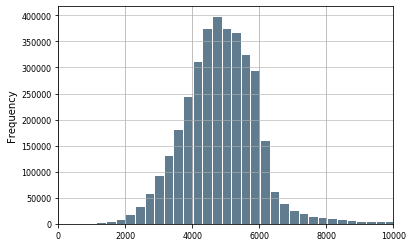

In [132]:
df['dist'].plot.hist(grid=True, bins=200, rwidth=0.9,
                   color='#607c8e', xlim=(0,10000))
params = {'axes.titlesize':'4',
          'xtick.labelsize':'4',
          'ytick.labelsize':'4'}
matplotlib.rcParams.update(params)
plt.grid(axis='y', alpha=0.75)

In [133]:
# top 10 most similar manifestos
df.sort_values(by = 'dist').head(10)

,dist,index_p1,index_p2,p1_d,p2_d
860382,0.0,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,Політична програма кандидата в наро...,Політична програма кандидата в наро...
178801,37.0,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,ПЕРЕДВИБОРЧА ПРОГР...,ПЕРЕДВИБОРЧА ПРОГР...
1921767,52.0,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,Передвиборна прогр...,Передвиборна прогр...
3581366,53.0,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,Пункти передвиборч...,Пункти передвиборч...
3208073,55.0,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,Передвиборча програма кандидата у нар...,Передвиборча програма кандидата у нар...
975879,61.0,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,Гаврилюк Василь Васильович кандидат в нар...,Рибак Ю.О. кандидат в народні депутати України...
2774542,63.0,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,Передвиборна програма кандидата у нар...,Передвиборна програма кандидата у нар...
3595017,65.0,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,2\t\t2ПЕРЕДВИБОРНА ПРОГРАМАкандидата у народні...,2\t\t2ПЕРЕДВИБОРНА ПРОГРАМАкандидата у народні...
920372,66.0,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,Передвиборна програма кандидата у...,Передвиборна програма кандидата у...
2519614,66.0,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,Передвиборна прогр...,Передвиборна прогр...


In [186]:
# for each program choosing corresponding pair with lowest distance
manifestos_grams_dist = df.sort_values('dist').drop_duplicates(['index_p1'])

In [187]:
# storing in local dir
manifestos_grams_dist[['dist', 'index_p1', 'index_p2']].to_csv('/home/olena/CHESNO/manifestos_grams_dist.csv')

In [29]:
# manifestos_grams_dist = pd.read_csv('/home/olena/CHESNO/manifestos_grams_dist', low_memory = False)

In [73]:
# fun for similarity ratio calculation

from diff_match_patch import diff_match_patch

def compute_similarity_and_diff(text1, text2):
    dmp = diff_match_patch()
    dmp.Diff_Timeout = 0.0
    diff = dmp.diff_main(text1, text2, False)

    # similarity
    common_text = sum([len(txt) for op, txt in diff if op == 0])
    text_length = max(len(text1), len(text2))
    sim = common_text / text_length

    return sim

In [75]:
# calculating similarity ratio for pairs with lowest n-grams dist
from datetime import datetime

sim_list = []
i = 0

for index_p1, index_p2, p1_d, p2_d in zip(manifestos_grams_dist['index_p1'], 
                                          manifestos_grams_dist['index_p2'], 
                                          manifestos_grams_dist['p1_d'], 
                                          manifestos_grams_dist['p2_d']):
        
    i += 1
        
    sim_dict = {}
    sim_dict['index_p1'] = index_p1
    sim_dict['index_p2'] = index_p2
    sim_dict['sim_ratio'] = compute_similarity_and_diff(str(p1_d).lower(),str(p2_d).lower()) # or maybe better to try Jaccard

    sim_list.append(sim_dict)

    if i % 100 == 0:
        print(i, datetime.now())

100 2019-07-10 12:58:20.847001
200 2019-07-10 12:58:51.228311
300 2019-07-10 12:59:32.025592
400 2019-07-10 13:00:18.824071
500 2019-07-10 13:01:17.051244
600 2019-07-10 13:02:41.206859
700 2019-07-10 13:04:00.362993
800 2019-07-10 13:05:29.547378
900 2019-07-10 13:07:01.742968
1000 2019-07-10 13:09:08.047992
1100 2019-07-10 13:10:45.944789
1200 2019-07-10 13:13:05.411537
1300 2019-07-10 13:15:49.297253
1400 2019-07-10 13:18:23.610671
1500 2019-07-10 13:20:45.285073
1600 2019-07-10 13:24:00.840296
1700 2019-07-10 13:26:47.500873
1800 2019-07-10 13:30:25.083052
1900 2019-07-10 13:32:29.005577
2000 2019-07-10 13:35:20.684923
2100 2019-07-10 13:37:58.904870
2200 2019-07-10 13:40:33.378549
2300 2019-07-10 13:43:03.214835
2400 2019-07-10 13:45:46.609570
2500 2019-07-10 13:49:11.284880
2600 2019-07-10 13:52:24.194193


In [79]:
similar_programs = pd.DataFrame(sim_list)

In [80]:
similar_programs.shape

(2681, 3)

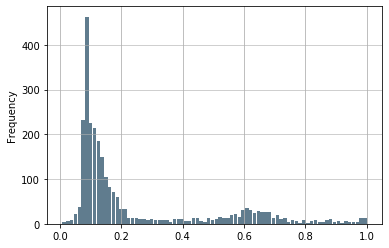

In [33]:
# distribution of similarity ratios

similar_programs['sim_ratio'].plot.hist(grid=True, bins=80, rwidth=0.9, color='#607c8e')
params = {'axes.titlesize':'12',
          'xtick.labelsize':'12',
          'ytick.labelsize':'12'}
matplotlib.rcParams.update(params)
plt.grid(axis='y', alpha=0.75)

In [133]:
similar_programs.to_csv('/home/olena/CHESNO/similar_programs.csv')

In [30]:
# similar_programs = pd.read_csv('/home/olena/CHESNO/similar_programs.csv')
# similar_programs = similar_programs.drop('Unnamed: 0', axis=1)

In [31]:
# selecting only programs with level of similarity > 50%
similar_programs_top = similar_programs.loc[similar_programs['sim_ratio'] > 0.5]
print(similar_programs_top.shape)
similar_programs_top.head()

(528, 3)


,index_p1,index_p2,sim_ratio
0,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,1.000000
1,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,0.997111
2,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,0.997370
3,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,0.829907
4,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,0.993860


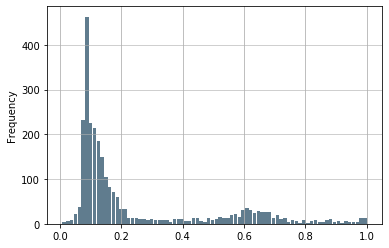

In [31]:
similar_programs['sim_ratio'].plot.hist(grid=True, bins=80, rwidth=0.9, color='#607c8e')
plt.grid(axis='y', alpha=0.75)

In [32]:
# adding info about candidates to manifestos (using link as unique to program on website of Electoral Comission)

merged_1 = pd.merge(similar_programs, programs[['name', 'url', 'Округ', 'Висування', 
                                                     'Дата реєстрації кандидатом']], how = 'left',
                    left_on = 'index_p1', right_on = 'url')
merged_1.columns = ['index_p1', 'index_p2', 'sim_ratio', 'name_p1', 'url_p1', 'Округ_p1', 'Висування_p1', 'p1_date']
merged = pd.merge(merged_1, programs[['name', 'url', 'Округ', 'Висування', 'Дата реєстрації кандидатом']], 
                  how = 'left', left_on = 'index_p2', right_on = 'url')
merged.columns = ['index_p1', 'index_p2', 'sim_ratio', 'name_p1', 'url_p1', 'Округ_p1', 'Висування_p1', 'p1_date',
                    'name_p2', 'url_p2', 'Округ_p2', 'Висування_p2', 'p2_date']
merged = merged[['index_p1', 'index_p2', 'sim_ratio', 'name_p1', 'Округ_p1', 'Висування_p1', 'p1_date', 'name_p2', 
                 'Округ_p2', 'Висування_p2', 'p2_date']]


In [33]:
plagiarism_dif_parties = merged.loc[(merged['Висування_p1'] == 'Самовисування') |
                                    (merged['Висування_p2'] == 'Самовисування') |
                                    (merged['Висування_p1'] != merged['Висування_p2'])]
plagiarism_diff = plagiarism_dif_parties.loc[plagiarism_dif_parties['sim_ratio'] > 0.5].sort_values(by = 'sim_ratio', ascending = False)
plagiarism_diff

,index_p1,index_p2,sim_ratio,name_p1,Округ_p1,Висування_p1,p1_date,name_p2,Округ_p2,Висування_p2,p2_date
2,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,0.997370,ІвановСергійВ’ячеславович,Одномандатний виборчий округ №160,Самовисування,25.06.2019,КачановСергійВікторович,Одномандатний виборчий округ №157,Самовисування,19.06.2019
1,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,0.997111,БабенкоМихайлоМиколайович,Одномандатний виборчий округ №205,Самовисування,23.06.2019,МахортовДмитроЮрійович,Одномандатний виборчий округ №23,Самовисування,21.06.2019
6,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,0.996509,МалькоВладиславАнатолійович,Одномандатний виборчий округ №25,Самовисування,23.06.2019,ПолярушЄвгенВалерійович,Одномандатний виборчий округ №28,Самовисування,24.06.2019
4,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,0.993860,ПлескачАнатолійАнатолійович,Одномандатний виборчий округ №150,Самовисування,23.06.2019,ТкаченкоОлександрЮрійович,Одномандатний виборчий округ №146,Самовисування,23.06.2019
14,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,0.993429,КлимоваОлександраВладиславівна,Одномандатний виборчий округ №26,Самовисування,23.06.2019,МалькоВладиславАнатолійович,Одномандатний виборчий округ №25,Самовисування,23.06.2019
7,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,0.990028,БоднарМихайлоМихайлович,Одномандатний виборчий округ №71,Самовисування,20.06.2019,УхачЄвгенІванович,Одномандатний виборчий округ №73,Самовисування,20.06.2019
8,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,0.989151,ВоловенкоОлександраВолодимирівна,Одномандатний виборчий округ №113,Самовисування,17.06.2019,ОлефірОленаІванівна,Одномандатний виборчий округ №174,Самовисування,18.06.2019
15,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,0.989075,МедведюкВасильАнтонович,Одномандатний виборчий округ №49,Самовисування,22.06.2019,МотрійОлександрВолодимирович,Одномандатний виборчий округ №50,Самовисування,22.06.2019
30,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,0.985125,КурилоПавлоМиколайович,Одномандатний виборчий округ №113,Самовисування,22.06.2019,СтрукВалерійМиколайович,Одномандатний виборчий округ №113,Самовисування,22.06.2019
26,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,0.983350,ПолярушЄвгенВалерійович,Одномандатний виборчий округ №28,Самовисування,24.06.2019,СімоновЮрійЮрійович,Одномандатний виборчий округ №27,Самовисування,23.06.2019


In [34]:
plagiarism_diff.to_csv('/home/olena/CHESNO/manifestos_plagiarism.csv')